**Abraham Nieto 51556 y Ricardo Lastra 160167**

**Examen 2 Parte 2**

# Pipeline 1

**Datos**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import feather
adults= feather.read_dataframe('adults.feather')
adults.head()

,age,workclass,fnlwgt,education,education_num,marital_status,ocupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**Transforma los datos para que estén en formato scikit-learn matriz de features $X$ vector de etiquetas $y$**

Utilizamo arrays de numpy para que queden en formato skearn

In [3]:
X_ad=adults.drop('income',axis=1)#Matriz de features
y_ad=adults['income']#vector de etiquetas
print(X_ad.shape)
print(y_ad.shape)

(32561, 14)
(32561,)


Pasamos $X$ y $y$ en formato sklearn

In [4]:
X =np.array(X_ad)#Features
y=np.array(y_ad).reshape(32561,1)#Etiquetas
X.shape

(32561, 14)

**Separa el set en entrenamiento y pruebas 70/30**

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

**Separa el set de entrenamiento para obtener uno de validación del 8% del de training -ocupa como semilla la matrícula más chica de tu equipo**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=.08,random_state=51556)#semilla 51556

**Transformación de variables -si necesitas alguna-**

Vamos a estandarizar las variables numéricas para que tengan la misma escala y vamos a hacer label ecoder para las variables categóricas,i.e. vamos a codificar las clases de cada una de estas para tener variables numéricas.

Primero,creamos una clase para seleccionar las features de nuestro interés y después poder dividirlos en features numéricos y categóricos.

fuente:https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline

In [7]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,FunctionTransformer,OneHotEncoder
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        col_list = []
        for c in self.cols:
            col_list.append(X[:, c:c+1])
        return np.concatenate(col_list, axis=1)

    def fit(self, X, y=None):
        return self

Hacemos una segunda función para hacer un multilabel encoder, esto se hace ya que labelencoder no funciona para múltiples columnas, entonces es necsario hacer una función que lo haga.

Este programa se modificó para ajustarlo a nuestos datos.
fuente: https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [8]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                #print(col)
                output[:,col] = LabelEncoder().fit_transform(output[:,col])
        #else:
        #    for colname,col in output.iteritems():
         #       output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

Para tratar un Dataframe con datos mezclados vamos a hacer escalamiento de la variables numéricas y labelencoder o codificación de las categóricas.

Vamos a definir nuestra función FCB_filtering para después ocuparla en el pipeline.

**Feature engineering: Utiliza tu función FCB_filtering() para seleccionar las variables con mayor correlación a la variable target**

In [9]:

#Hacemos diccionario de variables dado que la función FCB trabaja con dataframes necesitaremos un array 
#de salida y así ligar las variables a la columna correspondiente del array.
my_dict = {'age' : 0, 'fnlwgt' : 1,'education_num' : 2, 'capital_gain' : 3,'capital_loss' : 4,
           'hours_per_week' : 5,'workclass' : 6, 'education' : 7,
          'marital_status' : 8, 'occupation' : 9,'relationship' : 10, 'race' : 11,'sex' : 12, 
           'native_country' : 13}

#Hacemos un pequeño pipeline que separa las variables en numéricas y categóricas y hace escalamiento y codifica
#las categóricas y luego las junta.
pip=Pipeline([('features', FeatureUnion([
        ('continuous',Pipeline([("nums", ColumnExtractor(cols=(0,2,4,10,11,12))), ("sc",StandardScaler())])),
        ('factors',Pipeline([("cat", ColumnExtractor(cols=(1, 3, 5, 6, 7, 8, 9,13))), 
                             ("oe",MultiColumnLabelEncoder(columns=(0,1,2,3,4,5,6,7)))])
)]))])



#Función para eliminar variables correlacionadas basado en que estas se relacionan con la variable target
#umbral de correlación default=|.2|
def FCB_filtering(umbral=.2,target='income'):#la función regresa la lista de variables a conservar ojo!
    
#aplicamos el pipe 'pip' a los datos de entrenamiento, estos datos los estamos creando para que la función
#FCB_filering los ocupe para seleccionar las variables más correlacionadas con el target pero en el entrenamiento
#y así aplicar está selección de variables a los datos de test usando un transform de la función sel_column
#ya que de no hacerlo así se aplicaría el filtering para cada partición de datos y  los resultados podrían ser
#distintos cuando usemos el transform.
    
    ax=pip.fit_transform(X_train).astype('float64')
    
    
    
    #if len(X)==len(X_train):
    #    y=y_train 
    #elif(len(X)==len(X_val)):
    #    y=y_val
        
    #else:
    #    y=y_test

    
    
    
    num=list(adults.select_dtypes(['float64','int32']))
    nom=list(adults.select_dtypes(['object']).drop(target,axis=1,inplace=False))
    varib=num+nom

    df=pd.DataFrame(ax,columns=varib)
    df[target]=LabelEncoder().fit_transform(y_train)
    #df[target]=df[target].apply(lambda x: 1.0 if x==">50K" else 0.0)

    kp=[]
    nmkp=[]
    features=[x for x in list(df) if not (x==target)]
    numf=1
    aux=df
    while(numf>0):#mientras tengamos una lista de variables correlacionadas econ el target...
        dfc=aux[features].corr()#hacemos la matriz de correlaciones de las variables distintas del target
    
        tabcor=pd.DataFrame(features,columns=[['variable']])
        tabcor['correlacion']=0#creamos un dataframe con una columna donde llenaremos la correlación de
        #de las variables vs. el target
        j=0
        for i in tabcor['variable']:
            #print(aux[i])
            tabcor['correlacion'].iloc[j]=np.corrcoef(aux[i], aux[target])[1][0]#correlación de variables y target
            j=j+1
        tabcor['abscor']=abs(tabcor['correlacion'])#creamos correlaciones en valor absoluto para ordenar
        #las variables más correlacionadas con el target positiva o negativamente
        tabcor.sort_values(by='correlacion',ascending=False) 
        ax = plt.axes()
        sns.barplot(y='variable',x='correlacion',data=tabcor.sort_values(by='correlacion',ascending=False))
        ax.set_title('Correlación variables con el target')
        plt.show()#graficamos las correlaciones vs. el target en cada paso
        sal=tabcor.sort_values(by='abscor',ascending=False)
        sal=sal[abs(sal['abscor'])>umbral]
        numf=len(sal)
        
        if numf>0:
            
            maxvar=sal['variable'].iloc[0]#tomamos la variable con mayor correlación
            kp.append(my_dict[maxvar])
            nmkp.append(maxvar)
            ll=dfc[abs(dfc[maxvar])>umbral][maxvar].index
            #ll=ll[ll!=maxvar]
            print(' tira ',ll[ll!=maxvar])
            print(sal)
            aux=aux.drop(ll, axis=1, inplace=False)#borramos las variables más corelacionadas con nuestra
            #variable número1(la más correlacionada con el target)
            features=[x for x in list(aux) if not (x==target)]#quitamos las variables correlacionadas incluyendo
            #la variable de referencia para dar paso a la siguiente de la lista.
    print('las variables seleccionadas son:',nmkp)
    return(kp)

#Función para seeccionar las varibles más correlacionadas con el target según FCB_filtering.
def sel_column(X):
    return X[:, FCB_filtering()]


**Pipeline del proceso**

Hacemos un pipeline con feature union para juntar las variables numéricas escaladas y las categoricas codificadas, y al final aplicar sel_column que usa  FCB_filtring para tener sólo las variables finales con las que nos quedaremos, notar que para usar estas funciones es necesario llamar dentro de nuestro pipeline la función FunctionTransformer.


/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abraham/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

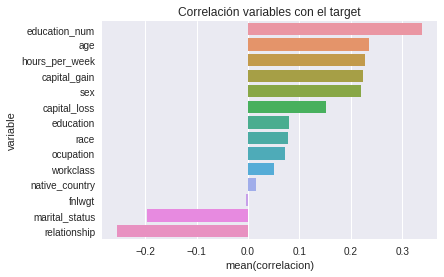

 tira  Index(['education'], dtype='object')
          variable  correlacion    abscor
2    education_num     0.337865  0.337865
10    relationship    -0.253901  0.253901
0              age     0.235741  0.235741
5   hours_per_week     0.228352  0.228352
3     capital_gain     0.222991  0.222991
12             sex     0.218787  0.218787


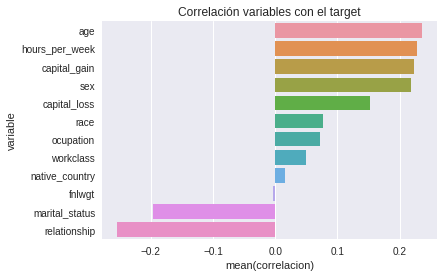

 tira  Index(['age', 'hours_per_week', 'sex'], dtype='object')
          variable  correlacion    abscor
8     relationship    -0.253901  0.253901
0              age     0.235741  0.235741
4   hours_per_week     0.228352  0.228352
2     capital_gain     0.222991  0.222991
10             sex     0.218787  0.218787


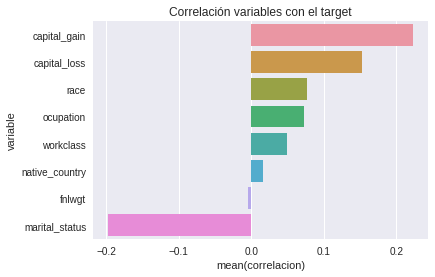

 tira  Index([], dtype='object')
       variable  correlacion    abscor
1  capital_gain     0.222991  0.222991


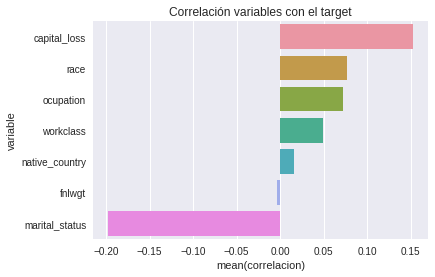

las variables seleccionadas son: ['education_num', 'relationship', 'capital_gain']


In [10]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous',Pipeline([("nums", ColumnExtractor(cols=(0,2,4,10,11,12))), ("sc",StandardScaler())])),
        ('factors',Pipeline([("cat", ColumnExtractor(cols=(1, 3, 5, 6, 7, 8, 9,13))), 
                             ("oe",MultiColumnLabelEncoder(columns=(0,1,2,3,4,5,6,7)))])
)])),('func', FunctionTransformer(sel_column))])
trX_train=pipeline.fit_transform(X_train)#transformamos X_train con el pipeline

In [11]:
#array final con las variables seleccionadas
trX_train

array([[-0.03573599,  0.        , -0.14603132],
       [-0.42458512,  4.        , -0.14603132],
       [-0.03573599,  1.        , -0.14603132],
       ..., 
       [ 0.74196227,  4.        , -0.14603132],
       [-0.42458512,  0.        , -0.14603132],
       [-0.42458512,  4.        , -0.14603132]])

/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abraham/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

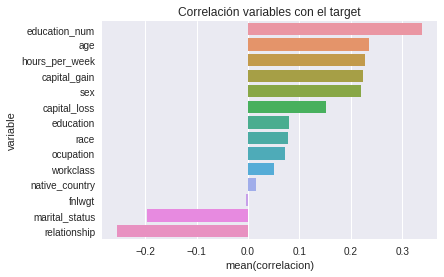

 tira  Index(['education'], dtype='object')
          variable  correlacion    abscor
2    education_num     0.337865  0.337865
10    relationship    -0.253901  0.253901
0              age     0.235741  0.235741
5   hours_per_week     0.228352  0.228352
3     capital_gain     0.222991  0.222991
12             sex     0.218787  0.218787


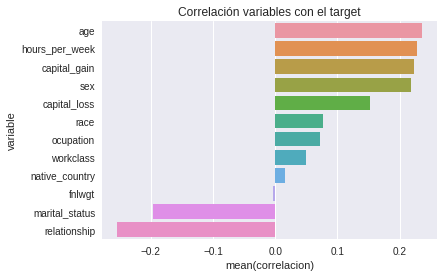

 tira  Index(['age', 'hours_per_week', 'sex'], dtype='object')
          variable  correlacion    abscor
8     relationship    -0.253901  0.253901
0              age     0.235741  0.235741
4   hours_per_week     0.228352  0.228352
2     capital_gain     0.222991  0.222991
10             sex     0.218787  0.218787


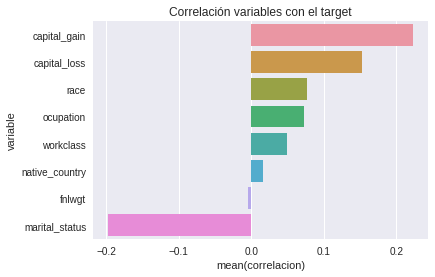

 tira  Index([], dtype='object')
       variable  correlacion    abscor
1  capital_gain     0.222991  0.222991


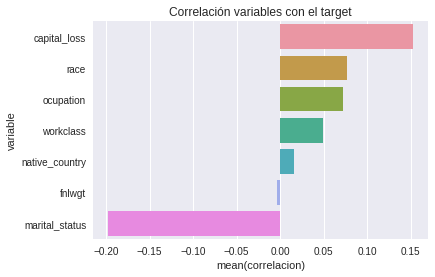

las variables seleccionadas son: ['education_num', 'relationship', 'capital_gain']


In [12]:
#Aplicamos transform a los datos de test con el pipeline, estos los ocuparemos para la parte 2
trx_test=pipeline.transform(X_test).astype('float64')

In [13]:
trx_test

array([[-1.97998164,  0.        , -0.14603132],
       [ 1.1308114 ,  1.        , -0.14603132],
       [-0.03573599,  1.        , -0.14603132],
       ..., 
       [-0.42458512,  1.        , -0.14603132],
       [ 1.1308114 ,  3.        , -0.14603132],
       [ 1.1308114 ,  1.        , -0.14603132]])

# Pipeline2

**Genera tu MagicLoop ocupando un RandomForest y un árbol para realizar la clasificación de income 
Prueba con los siguientes hiperparámetros utilizando el algoritmo GridSearch $\rightarrow$ NO se te olvide hacer cross-validation!!!
RandomForest: número de árboles: 500, 700, 800, 1000
número de árboles: 500, 700, 800, 1000
mtry: 3, 4, 5, 6, 7
nodesize: 7, 11, 13, 15
Árboles:
nodesize: 7, 11, 13, 15**

Definimos primero la función que va a tomar los hiperparámetros y los modelos a probar en este caso un árbol y un random forest

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc,precision_recall_curve
from sklearn.metrics import roc_curve,average_precision_score,precision_score

**Definimos una función para gráficos.**

In [15]:
def eval_offline(y_true,model,label,data):
    #función que pide respuestas, score y etiqueta equivalente el evento i.e. 1
    ###Gráficamos Curva ROC
    fpr, tpr, thresholds=roc_curve(y_true,model.predict_proba(data)[:,1],pos_label=label)
    win_auc=auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC win (area = %0.2f)' % win_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    ###Graficamos precision vs. recall, aquí aparecerá el AUC del modelo en datos de prueba(test)
    precision, recall, _ = precision_recall_curve(y_true, model.predict_proba(data)[:,1],pos_label=label)

    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()  
    


    
    print('El AREA BAJO LA CURVA AUC ES:',auc(fpr,tpr))
    
    
    

Función de double density

In [16]:
def acum(base,var):
    cum=np.zeros(len(base))
    for i in range(len(base)):
        if i==0:
            cum[i]=base[var].iloc[i]
        else:
            cum[i]=cum[i-1]+base[var].iloc[i]
    return(cum)

def plot_double_density(model,y_true,data):
    yy=LabelEncoder().fit_transform(y_true) 
    
    data=pd.DataFrame(np.array(model.predict_proba(data)[:,1]),columns=['score'])
    data['target']=np.array(yy)
    
    data['no_target'] = 1 - data.target
    # particiones

    #data['bucket'] = pd.qcut(data.score, buckets)

    # GROUP THE DATA FRAME BY BUCKETS

    #grouped = data.groupby('bucket', as_index = False)

    # CREATE A SUMMARY DATA FRAME

    #agg1 = grouped.min().score 

    #agg1 = pd.DataFrame(grouped.min().score) 
    #agg1.rename(columns={'score': 'min_scr'},inplace=True)
                                                    
    #agg1['max_scr'] = grouped.max().score

    #agg1['target'] = grouped.sum().target

    #agg1['no_target'] = grouped.sum().no_target

    data['total'] = data.target + data.no_target


    # SORT THE DATA FRAME BY SCORE

    agg2 = (data.sort_values(by = 'score',ascending=False)).reset_index(drop = True)

    agg2['FPR'] = (agg2.no_target / agg2.target)

    agg2['event_rate'] = (agg2.target / agg2.total).apply('{0:.2%}'.format)

    # CALCULATE KS STATISTIC

    agg2['ks'] = np.round(((agg2.target / data.target.sum()).cumsum() - (agg2.no_target / data.no_target.sum()).cumsum()), 4) * 100

    # DEFINE A FUNCTION TO FLAG MAX KS

    flag = lambda x: '<----' if x == agg2.ks.max() else ''

    # FLAG OUT MAX KS

    agg2['max_ks'] = agg2.ks.apply(flag)


    orig=float(agg2['target'].sum()/agg2['total'].sum()) 



    agg2['cumtotal']=acum(agg2,'total')
    agg2['cum_target']=acum(agg2,'target')
    agg2['cum_no_target']=acum(agg2,'no_target') 
    agg2['cum_FPR'] = (agg2.cum_no_target / agg2.cum_target).apply('{0:.2f}'.format) 
    agg2['cum_event_rate'] = (agg2.cum_target / agg2.cumtotal).apply('{0:.2%}'.format) 
    agg2['cum_TP'] = (agg2.cum_target / agg2['target'].sum()).apply('{0:.2%}'.format) 
    agg2['cum_FP'] = (agg2.cum_no_target / agg2['no_target'].sum()).apply('{0:.2%}'.format) 
    agg2['%Universo'] = (agg2.cumtotal / agg2.cumtotal.max()).apply('{0:.2%}'.format)
    agg2['LIFT'] = ((agg2.cum_target / agg2.cumtotal)/orig)

    agg2['Recall'] = (agg2.cum_target / agg2['target'].sum())
    agg2['Precision'] = (agg2.cum_target / agg2.cumtotal)
    agg2['FPrate'] = (agg2.cum_no_target / agg2['no_target'].sum()) 
    agg2['%Ctes'] = (agg2.cumtotal / agg2.cumtotal.max()) 
    
    plt.figure(figsize=(10,6))
    data[data['target']==1]['score'].plot.kde(label='>50k',xlim=[0,1])
    
    data[data['target']==0]['score'].plot.kde(label='<=50k',xlim=[0,1])
    plt.legend()
    plt.xlabel('Score')
    plt.title('Double Density')



    pass  

In [17]:
def define_hyper_params():
    """
        Esta función devuelve un diccionario con
        los clasificadores que vamos a utilizar y
        una rejilla de hiperparámetros
    """
    ## Por ejemplo
    # Create space of candidate learning algorithms and their hyperparameters
    classifier = {
         'DT': DecisionTreeClassifier()
     }
    
    search_space = [{'classifier': [DecisionTreeClassifier()],
                 'classifier__min_samples_split': [7, 11, 13, 15],
                 },
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [500, 700, 800, 1000],
                 'classifier__max_features': ['auto','log2'],
                 'classifier__min_samples_split': [7, 11, 13, 15]}]

    return (classifier,search_space)


Función magic_loop regresa los mejores parámetros para cada modelo a probar, en este caso un Random Forest y un árbol, usando un pipeline que pase los 2 modelos (árbol y Random Forest).

In [18]:
def magic_loop(X_train, y_train,X_test,y_test,models_to_run=['DT','RF']):
    
    y=LabelEncoder().fit_transform(y_train)

   
    classifier,search_space=define_hyper_params()#Modelos y parámetros efinidos que vamos a usar
    #Hacemos un pipeline con el árbol.
    pipe = Pipeline([('classifier', classifier[models_to_run[0]])])
    #después en los parámetros vamos a probar el mejor modelo entre el árbol, el RF y sus parámetros respectivos
    #usando el gridsearch pero a diferencia de lo común, este nos va a comparar, usando cross-validation,
    #2 modelos y sus combinaciones de parámetros y nos regresará el mejor modelo con sus mejores parámetros.
    #hacemos 10 cross-validation y usamos F1-score como métrica de comparación. 
    clf = GridSearchCV(pipe, search_space, cv=10, verbose=3,scoring='f1',n_jobs=-1)
    #ajustamos el mejor modelo
    best_model = clf.fit(X_train, y)
    #obtenemos el mejor modelo y sus parámetros
    win=best_model.best_estimator_.get_params()['classifier']

    #tenemos modelo ganador y lo ajustamos    
    win.fit(X_train, y)
    
    print('EVALUACION OFFLINE:')
    
    eval_offline(y_test,win,'>50K',X_test)
    
    plot_double_density(win,y_test,X_test)
    
    print('Mejor modelo fue:' ,win)
    return(win)#Regresa el mejor modelo             

De acuerdo con los resultados del pipeline1 nos vamos a quedar con las variables seleccionadas por nuestra función filtering, entonces vamos a darle de entrada al magic loop X's  y y's de entrenmiento y test como entradas.

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), classifier__min_samples_split=7 [CV] classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), classifier__min_samples_split=7 
[CV] classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s


[CV]  classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), classifier__min_samples_split=15, score=0.670404 -   0.0s
[CV] classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), classifier__min_samples_split=15 
[CV]  classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_d

[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  4.2min


[CV]  classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), classifier__max_features=log2, classifier__min_samples_split=15, classifier__n_estimators=700, score=0.669653 -   7.8s
[CV] classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clas

[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.6min finished


EVALUACION OFFLINE:


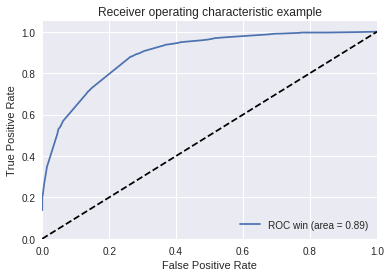

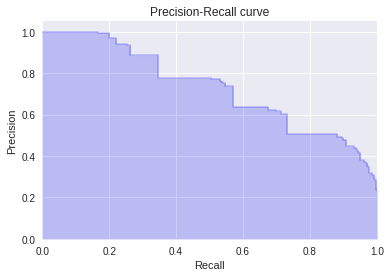

El AREA BAJO LA CURVA AUC ES: 0.890155388463


/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejor modelo fue: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


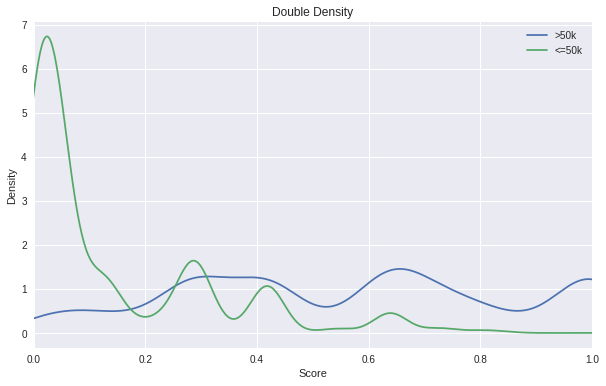

In [21]:
winner=magic_loop(trX_train, y_train,trx_test,y_test,models_to_run=['DT','RF'])#Resultados del magic Loop

In [1]:
import matplotlib
matplotlib.__version__


'2.1.1'

Como dato cultural tomamos el modelo de salida del magic loop y evaluamos en test

In [22]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

winner.fit(trX_train, y_train) 
pred=winner.predict(trx_test) 
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

/home/abraham/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


             precision    recall  f1-score   support

      <=50K       0.87      0.94      0.91      7466
       >50K       0.75      0.54      0.63      2303

avg / total       0.84      0.85      0.84      9769

[[7051  415]
 [1048 1255]]
